In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")
plt.style.use("ggplot")
plt.style.use("fivethirtyeight")


## Housely Time Series Forecasting using Prophet

Forecast hourly energy use

In [2]:
def MAPE(y_true: np.array, y_pred: np.array) -> np.array:
    """
    mean absolute percentage error given y_true and y_pred
    """
    return np.mean(np.abs((y_true-y_pred)/y_true)) * 100


## Data
The data we will be using is hourly power consumption data from PJME consumption

In [3]:
pjme_df = pd.read_csv(".\PJME_hourly.csv", index_col=[0], parse_dates=['Datetime'])
pjme_df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [57]:
pjme_df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


Pulling the PJM East which has data from 2002-2018 for the entire east region.

In [58]:
color_pal = sns.color_palette()
color_pal

[(0.0, 0.5607843137254902, 0.8352941176470589),
 (0.9882352941176471, 0.30980392156862746, 0.18823529411764706),
 (0.8980392156862745, 0.6823529411764706, 0.2196078431372549),
 (0.42745098039215684, 0.5647058823529412, 0.30980392156862746),
 (0.5450980392156862, 0.5450980392156862, 0.5450980392156862),
 (0.5058823529411764, 0.058823529411764705, 0.48627450980392156)]

<AxesSubplot:title={'center':'PJME MW'}, xlabel='Datetime'>

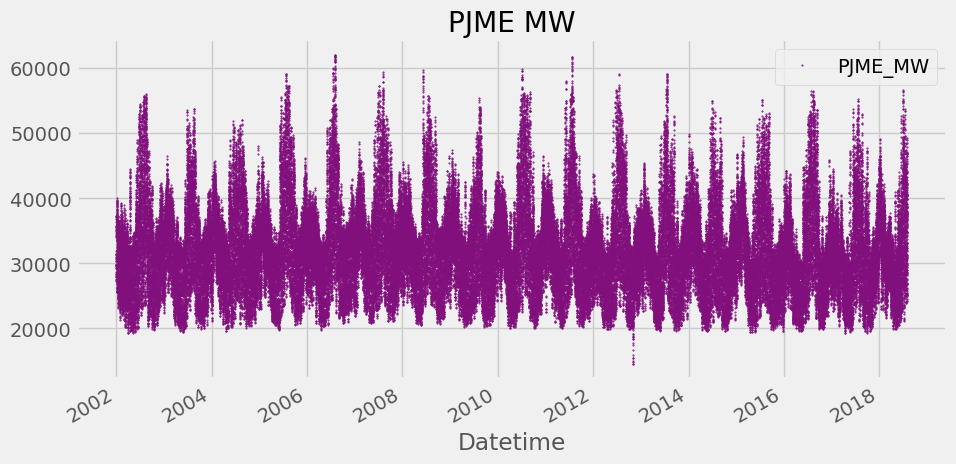

In [59]:
pjme_df.plot(style='.',
            figsize=(10,5),
            ms=1,
            color=color_pal[-1],
            title='PJME MW')

## Features

In [4]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Features created from datetime index
    """
    df = df.copy()
    df["date"] = df.index
    df["hour"] = df.date.dt.hour
    df["dayofweek"] = df.date.dt.dayofweek
    df["weekday"] = df.date.dt.day_name()
    df["weekday"] = df.weekday.astype(cat_type)
    df["quarter"] = df.date.dt.quarter
    df["month"] = df.date.dt.month
    df["year"] = df.date.dt.year
    df["dayofyear"] = df.date.dt.dayofyear
    df["dayofmonth"] = df.date.dt.day
    df["weekofyear"] = df.date.dt.weekofyear
    df["date_offset"] = (df.date.dt.month*100+df.date.dt.day-320)%1300

    df["season"] = pd.cut(df["date_offset"], [0, 300, 602, 900, 1300],
                            labels=["Spring", "Summer", "Fall", "Winter"])
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y 
    return X 

In [5]:
X, y = create_features(pjme_df, label='PJME_MW')


In [6]:
X.shape, y.shape

((145366, 10), (145366,))

In [7]:
features_and_target = pd.concat([X,y], axis=1)
features_and_target.shape

(145366, 11)

In [8]:
features_and_target

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,PJME_MW
Datetime,,,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,Tuesday,Winter,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,Tuesday,Winter,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,Tuesday,Winter,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,Tuesday,Winter,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,Tuesday,Winter,24860.0
...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,20,0,1,1,2018,1,1,1,Monday,Winter,44284.0
2018-01-01 21:00:00,21,0,1,1,2018,1,1,1,Monday,Winter,43751.0
2018-01-01 22:00:00,22,0,1,1,2018,1,1,1,Monday,Winter,42402.0


In [9]:
features_and_target.weekday.value_counts()

Wednesday    20784
Thursday     20784
Tuesday      20783
Monday       20760
Friday       20760
Saturday     20760
Sunday       20735
Name: weekday, dtype: int64

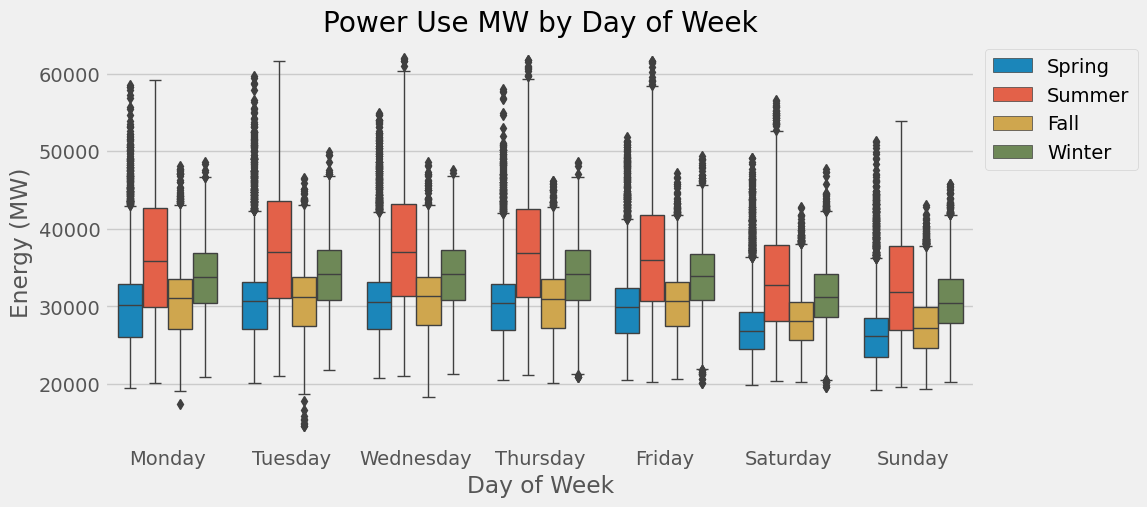

In [81]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target,
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

In [83]:
pjme_df.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

## train test split

In [10]:
split_date = "1-Jan-2015"
pjme_train = pjme_df.loc[pjme_df.index <= split_date].copy()
pjme_test = pjme_df.loc[pjme_df.index > split_date].copy()
pjme_train.sort_index()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2014-12-31 20:00:00,37772.0
2014-12-31 21:00:00,36602.0
2014-12-31 22:00:00,35326.0


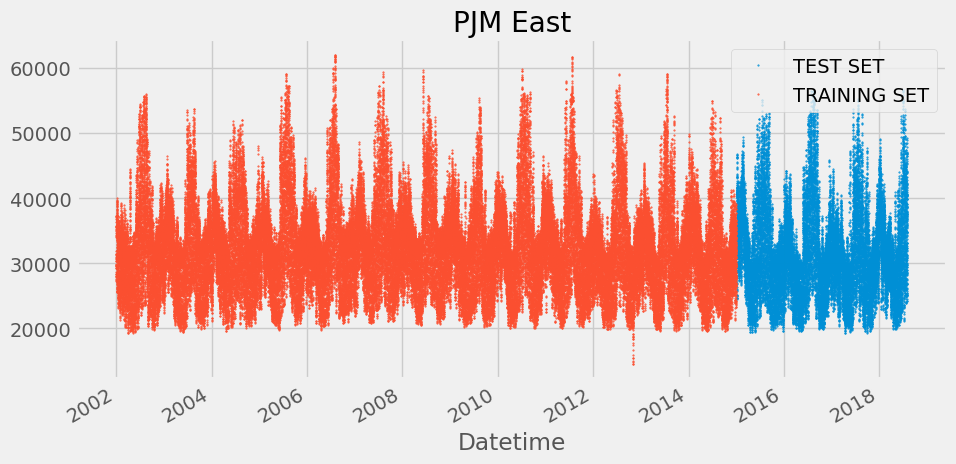

In [97]:
# plot train and test so you can see where we can split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='PJM East', style='.', ms=1)
plt.show()

## Simple Prophet model
Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
- Datetime column named: ds
- target : y

In [11]:
pjme_train_prophet = pjme_train.reset_index().rename(columns={"Datetime": "ds", "PJME_MW": "y"})
pjme_train_prophet

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
113922,2014-01-01 20:00:00,36193.0
113923,2014-01-01 21:00:00,35601.0
113924,2014-01-01 22:00:00,34242.0
113925,2014-01-01 23:00:00,32215.0


In [99]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

09:17:33 - cmdstanpy - INFO - Chain [1] start processing
09:19:45 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 7.58 s
Wall time: 2min 19s


In [100]:
# predict on test set with model
pjme_test_prophet = pjme_test.reset_index()\
                .rename(columns={"Datetime": "ds", "PJME_MW": "y"})
pjme_test_predict = model.predict(pjme_test_prophet)

In [101]:
pjme_test_predict

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31203.428443,24088.161697,32925.465925,31203.428443,31203.428443,-2845.249382,-2845.249382,-2845.249382,-4430.355857,...,1281.388794,1281.388794,1281.388794,303.717681,303.717681,303.717681,0.0,0.0,0.0,28358.179061
1,2015-01-01 02:00:00,31203.390393,22176.853248,31224.890435,31203.390393,31203.390393,-4349.694004,-4349.694004,-4349.694004,-5927.332380,...,1272.625061,1272.625061,1272.625061,305.013315,305.013315,305.013315,0.0,0.0,0.0,26853.696389
2,2015-01-01 03:00:00,31203.352343,21609.696262,30326.305737,31203.352343,31203.352343,-5221.371965,-5221.371965,-5221.371965,-6790.378010,...,1262.655592,1262.655592,1262.655592,306.350452,306.350452,306.350452,0.0,0.0,0.0,25981.980378
3,2015-01-01 04:00:00,31203.314293,21240.465943,30555.765779,31203.314293,31203.314293,-5362.820050,-5362.820050,-5362.820050,-6922.153232,...,1251.604062,1251.604062,1251.604062,307.729120,307.729120,307.729120,0.0,0.0,0.0,25840.494243
4,2015-01-01 05:00:00,31203.276243,21906.716648,31283.000512,31203.276243,31203.276243,-4688.373560,-4688.373560,-4688.373560,-6237.129258,...,1239.606356,1239.606356,1239.606356,309.149342,309.149342,309.149342,0.0,0.0,0.0,26514.902682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31434,2018-08-02 20:00:00,30007.320967,-5058.344658,86020.862009,-17144.747732,74654.172770,11272.125854,11272.125854,11272.125854,4450.968703,...,1033.822922,1033.822922,1033.822922,5787.334228,5787.334228,5787.334228,0.0,0.0,0.0,41279.446821
31435,2018-08-02 21:00:00,30007.282917,-7385.125021,84327.772884,-17147.242876,74655.700865,10499.415254,10499.415254,10499.415254,3695.821579,...,1021.208369,1021.208369,1021.208369,5782.385307,5782.385307,5782.385307,0.0,0.0,0.0,40506.698171
31436,2018-08-02 22:00:00,30007.244867,-7755.847542,83440.231180,-17149.738021,74657.228959,8870.316548,8870.316548,8870.316548,2084.445836,...,1008.435871,1008.435871,1008.435871,5777.434841,5777.434841,5777.434841,0.0,0.0,0.0,38877.561415
31437,2018-08-02 23:00:00,30007.206817,-9759.184751,81546.102095,-17152.233165,74658.757053,6662.651873,6662.651873,6662.651873,-105.142328,...,995.311279,995.311279,995.311279,5772.482921,5772.482921,5772.482921,0.0,0.0,0.0,36669.858689


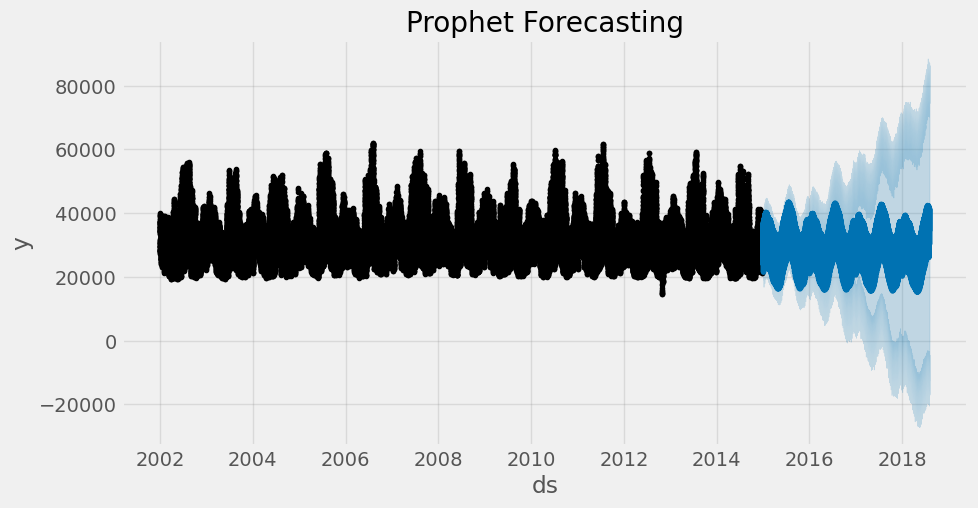

In [103]:
fig, ax = plt.subplots(figsize=(10,5))
fig = model.plot(pjme_test_predict, ax=ax)
ax.set_title("Prophet Forecasting")
plt.show()



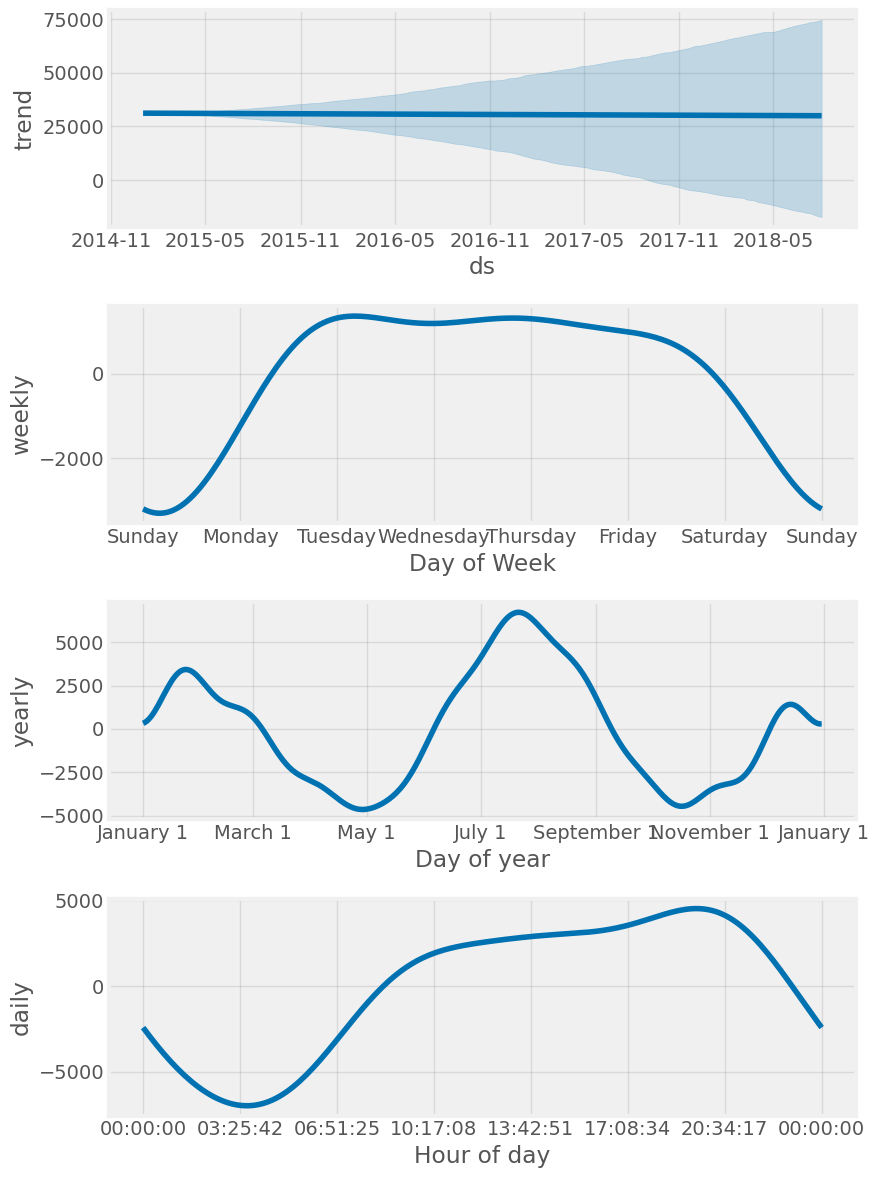

In [105]:
fig = model.plot_components(pjme_test_predict)
plt.show()

## Compare forecast to actuals

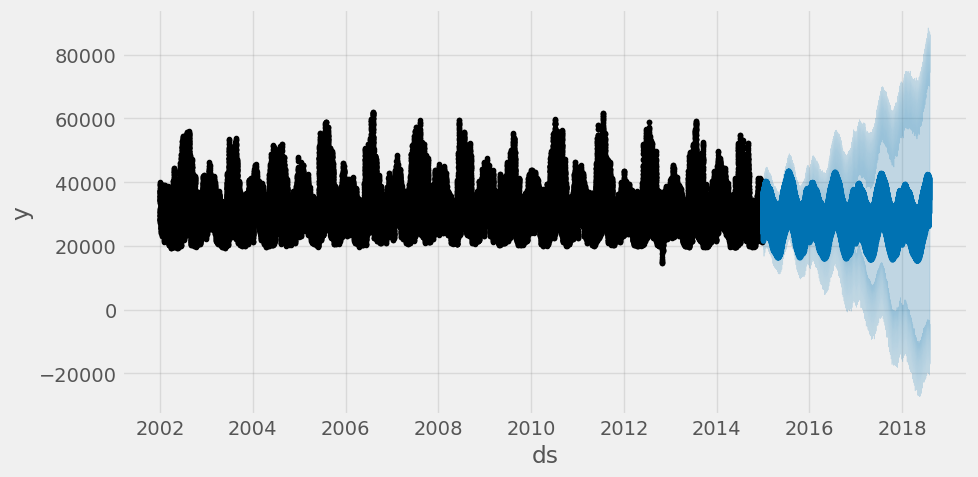

In [118]:
fig, ax = plt.subplots(figsize=(10,5))
fig = model.plot(pjme_test_predict, ax=ax)


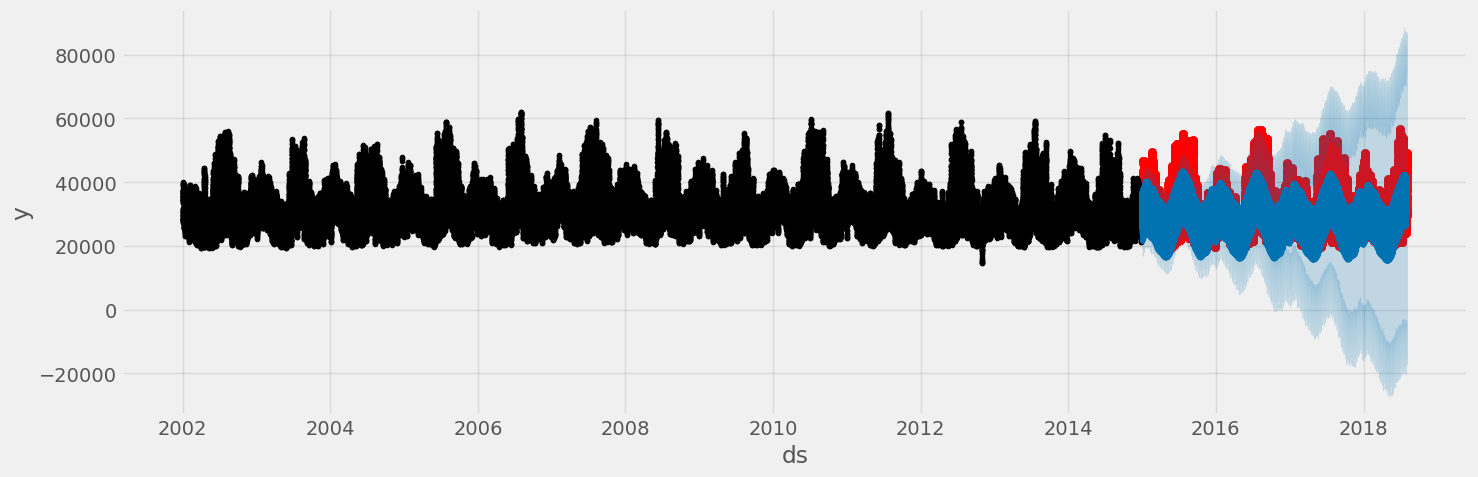

In [113]:
# Plot the forecast with the actuals
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_predict, ax=ax)

In [126]:
pjme_test

,PJME_MW
Datetime,
2015-12-31 01:00:00,24305.0
2015-12-31 02:00:00,23156.0
2015-12-31 03:00:00,22514.0
2015-12-31 04:00:00,22330.0
2015-12-31 05:00:00,22773.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


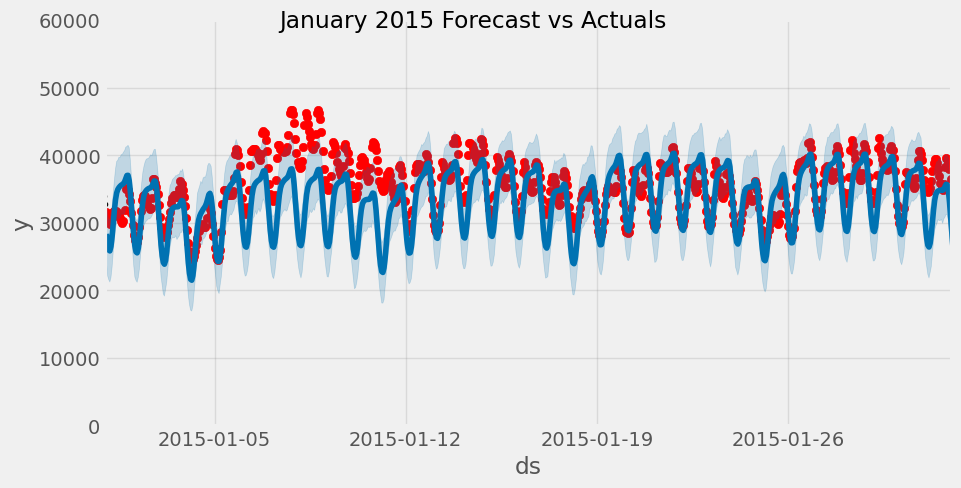

In [128]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_predict, ax=ax)
ax.set_xbound(lower=pd.to_datetime('2015-01-01', format="%Y-%m-%d"),
              upper=pd.to_datetime('2015-02-01', format="%Y-%m-%d"))
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

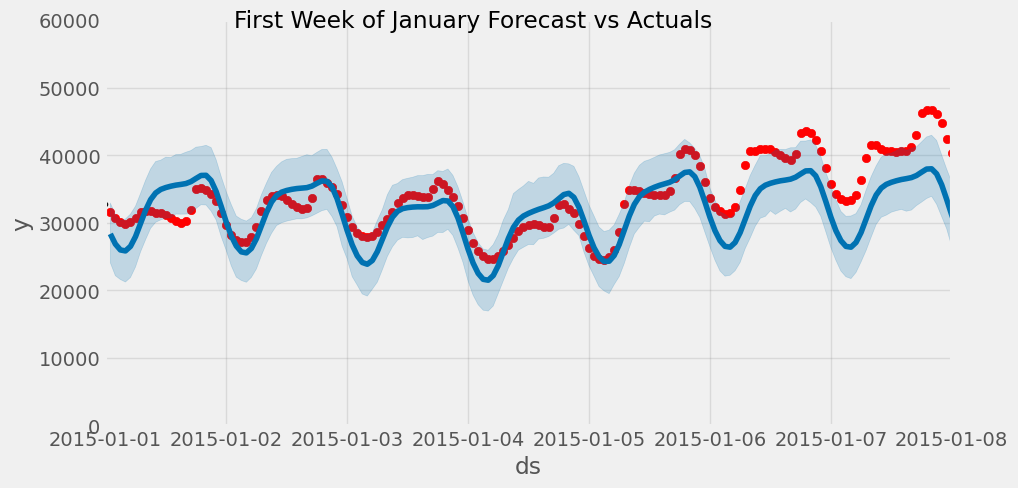

In [129]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_predict, ax=ax)
ax.set_xbound(lower=pd.to_datetime('2015-01-01', format="%Y-%m-%d"),
              upper=pd.to_datetime('2015-01-08', format="%Y-%m-%d"))
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

## Evaluate the model with Error Metrics

In [141]:
error = np.sqrt(mean_squared_error(y_true=pjme_test["PJME_MW"], y_pred=pjme_test_predict["yhat"]))
print(f"root mean squared error: {error}")

error = mean_absolute_error(y_true=pjme_test['PJME_MW'],
                    y_pred=pjme_test_predict['yhat'])
print(f"mean absolute error: {error}")

error = mean_absolute_percentage_error(y_true=pjme_test["PJME_MW"],
                    y_pred=pjme_test_predict["yhat"])
print(f"mean absolute percentage error: {error}")

error = MAPE(y_true=np.array(pjme_test["PJME_MW"]),
            y_pred=np.array(pjme_test_predict["yhat"]))
print(f"mean absolute percentage error: {round(error,2)}%")


root mean squared error: 6617.868136902021
mean absolute error: 5182.793987435976
mean absolute percentage error: 0.16506586588257766
mean absolute percentage error: 16.51%


## Adding holidays
Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a Holiday Effects parameter that can provided to the model prior to training.

In [146]:
from pandas.tseries.holiday import USFederalHolidayCalendar as uscalendar 

cal = uscalendar()
holidays = cal.holidays(start=pjme_df.index.min(),
                        end=pjme_df.index.max(),
                        return_name=True)
holidays

2002-01-21    Birthday of Martin Luther King, Jr.
2002-02-18                  Washington’s Birthday
2002-05-27                           Memorial Day
2002-07-04                       Independence Day
2002-09-02                              Labor Day
                             ...                 
2018-01-01                         New Year's Day
2018-01-15    Birthday of Martin Luther King, Jr.
2018-02-19                  Washington’s Birthday
2018-05-28                           Memorial Day
2018-07-04                       Independence Day
Length: 164, dtype: object

In [149]:
holidays_df =pd.DataFrame(holidays, columns=['holiday'])
holidays_df = holidays_df.reset_index().rename(columns={"index": "ds"})
holidays_df

,ds,holiday
0,2002-01-21,"Birthday of Martin Luther King, Jr."
1,2002-02-18,Washington’s Birthday
2,2002-05-27,Memorial Day
3,2002-07-04,Independence Day
4,2002-09-02,Labor Day
...,...,...
159,2018-01-01,New Year's Day
160,2018-01-15,"Birthday of Martin Luther King, Jr."
161,2018-02-19,Washington’s Birthday
162,2018-05-28,Memorial Day


In [151]:
%%time 
model_with_holidays = Prophet(holidays=holidays_df)
model_with_holidays.fit(pjme_train_prophet)

10:10:11 - cmdstanpy - INFO - Chain [1] start processing
10:12:25 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 8.95 s
Wall time: 2min 23s


In [152]:
#  predict on training set with model
pjme_test_predict_with_holidays = model_with_holidays.predict(df=pjme_test_prophet)

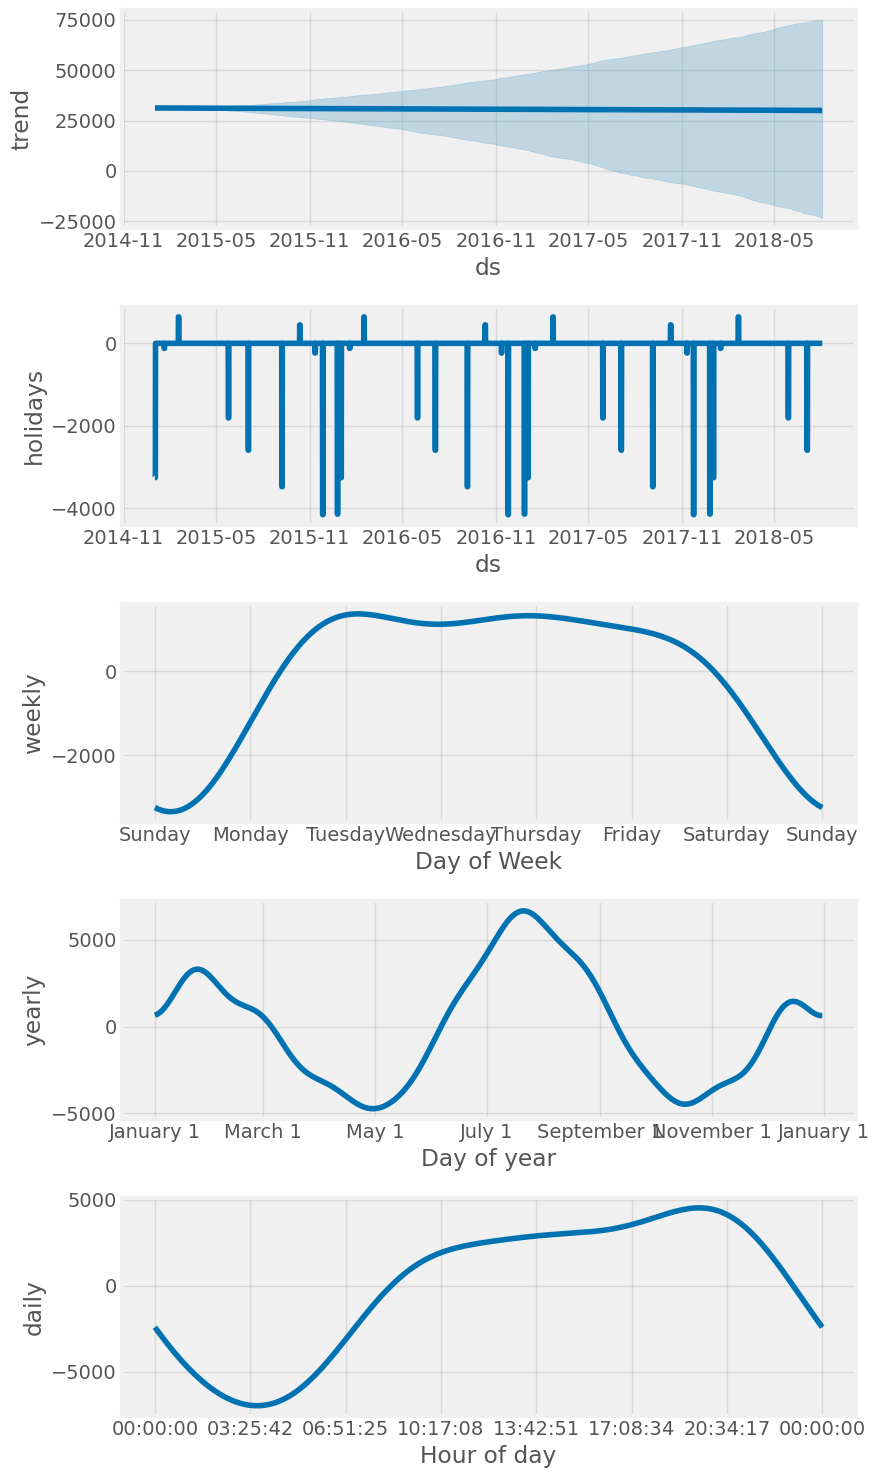

In [153]:
fig = model_with_holidays.plot_components(pjme_test_predict_with_holidays)
plt.show()

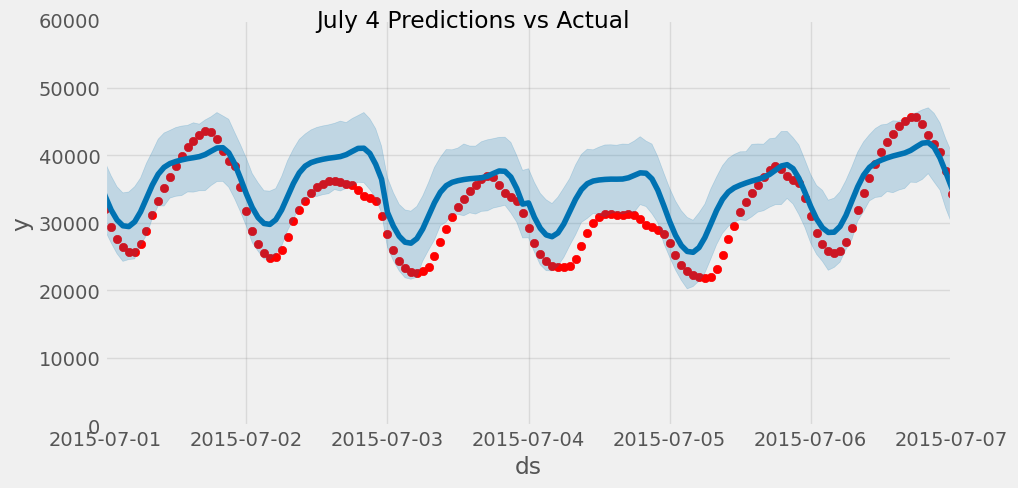

In [166]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model_with_holidays.plot(pjme_test_predict_with_holidays, ax=ax)
ax.set_xbound(lower=pd.to_datetime('2015-07-01', format="%Y-%m-%d"),
              upper=pd.to_datetime('2015-07-07', format="%Y-%m-%d"))
ax.set_ylim(0, 60000)
plot = plt.suptitle('July 4 Predictions vs Actual')

In [167]:
error = np.sqrt(mean_squared_error(y_true=pjme_test["PJME_MW"], y_pred=pjme_test_predict_with_holidays["yhat"]))
print(f"root mean squared error: {error}")

error = mean_absolute_error(y_true=pjme_test['PJME_MW'],
                    y_pred=pjme_test_predict_with_holidays['yhat'])
print(f"mean absolute error: {error}")

error = mean_absolute_percentage_error(y_true=pjme_test["PJME_MW"],
                    y_pred=pjme_test_predict_with_holidays["yhat"])
print(f"mean absolute percentage error: {error}")

error = MAPE(y_true=np.array(pjme_test["PJME_MW"]),
            y_pred=np.array(pjme_test_predict_with_holidays["yhat"]))
print(f"mean absolute percentage error: {round(error,2)}%")


root mean squared error: 6639.802219208022
mean absolute error: 5200.950215632645
mean absolute percentage error: 0.1656184356325992
mean absolute percentage error: 16.56%


## Predict the future

In [14]:
import gc 
gc.collect()
from prophet.serialize import model_to_json, model_from_json

def save_model(save_path, model):   
    with open(save_path, 'w') as fout:
        fout.write(model_to_json(model))  # Save model

def load_model(save_path):
    with open(save_path, 'r') as fin:
        model = model_from_json(fin.read())  # Load model
    return model 

In [15]:
model = load_model('model.json')

In [18]:
future = model.make_future_dataframe(periods=365*24, freq="h", include_history=False)
future.ds.sort_values()


0      2015-01-01 01:00:00
1      2015-01-01 02:00:00
2      2015-01-01 03:00:00
3      2015-01-01 04:00:00
4      2015-01-01 05:00:00
               ...        
8755   2015-12-31 20:00:00
8756   2015-12-31 21:00:00
8757   2015-12-31 22:00:00
8758   2015-12-31 23:00:00
8759   2016-01-01 00:00:00
Name: ds, Length: 8760, dtype: datetime64[ns]

In [19]:
forecast = model.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31203.428443,24198.890101,32883.518506,31203.428443,31203.428443,-2845.249382,-2845.249382,-2845.249382,-4430.355857,...,1281.388794,1281.388794,1281.388794,303.717681,303.717681,303.717681,0.0,0.0,0.0,28358.179061
1,2015-01-01 02:00:00,31203.390393,22351.943729,31446.575790,31203.390393,31203.390393,-4349.694004,-4349.694004,-4349.694004,-5927.332380,...,1272.625061,1272.625061,1272.625061,305.013315,305.013315,305.013315,0.0,0.0,0.0,26853.696389
2,2015-01-01 03:00:00,31203.352343,21296.609671,30364.243376,31203.352343,31203.352343,-5221.371965,-5221.371965,-5221.371965,-6790.378010,...,1262.655592,1262.655592,1262.655592,306.350452,306.350452,306.350452,0.0,0.0,0.0,25981.980378
3,2015-01-01 04:00:00,31203.314293,21373.367474,30263.163849,31203.314293,31203.314293,-5362.820050,-5362.820050,-5362.820050,-6922.153232,...,1251.604062,1251.604062,1251.604062,307.729120,307.729120,307.729120,0.0,0.0,0.0,25840.494243
4,2015-01-01 05:00:00,31203.276243,21729.661340,30956.894881,31203.276243,31203.276243,-4688.373560,-4688.373560,-4688.373560,-6237.129258,...,1239.606356,1239.606356,1239.606356,309.149342,309.149342,309.149342,0.0,0.0,0.0,26514.902682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2015-12-31 20:00:00,30870.299099,29905.819105,43970.481544,25604.319164,37071.485356,5776.987278,5776.987278,5776.987278,4450.968703,...,1033.822922,1033.822922,1033.822922,292.195652,292.195652,292.195652,0.0,0.0,0.0,36647.286377
8756,2015-12-31 21:00:00,30870.261048,28564.491505,42863.811936,25603.360485,37072.248156,5010.066933,5010.066933,5010.066933,3695.821579,...,1021.208369,1021.208369,1021.208369,293.036986,293.036986,293.036986,0.0,0.0,0.0,35880.327982
8757,2015-12-31 22:00:00,30870.222998,26643.286226,41661.968412,25602.401806,37073.010957,3386.801125,3386.801125,3386.801125,2084.445836,...,1008.435871,1008.435871,1008.435871,293.919418,293.919418,293.919418,0.0,0.0,0.0,34257.024123
8758,2015-12-31 23:00:00,30870.184948,24708.816143,39678.535281,25601.443128,37073.773757,1185.011946,1185.011946,1185.011946,-105.142328,...,995.311279,995.311279,995.311279,294.842995,294.842995,294.842995,0.0,0.0,0.0,32055.196894


In [21]:
 pd.to_datetime('2015-12-31', format="%Y-%m-%d")

Timestamp('2015-12-31 00:00:00')